In [1]:
import pandas as pd
import os
import sys
import numpy as np
from tqdm import tqdm

tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:

refs = [
     '../model_predictions/comet/full_dec_comet_mixture_model_gaussian_2_predictions.parquet',
    '../model_predictions/comet/full_dec_comet_mixture_model_gaussian_3_predictions.parquet',
    '../model_predictions/comet/full_dec_comet_mixture_model_student-t_2_predictions.parquet',
    '../model_predictions/comet/full_dec_comet_mixture_model_student-t_3_predictions.parquet',
]

dists = [
    'gaussian',
    'gaussian',
    'student-t',
    'student-t',

]

dfs = [
    pd.read_parquet(ref) for ref in refs
]


In [3]:
import torch
import torch.distributions as td
from CustomLoss.GaussianMixtureLoss import GaussianMixtureLoss
from CustomLoss.StudentTMixtureLoss import StudentTMixtureLoss

class GaussianMixture:
    

    def create_mixture(self, loc, scale, weights,):
        loc = torch.Tensor(loc)
        scale = torch.Tensor(scale)
        weights = torch.Tensor(weights)
        shape = loc.shape
        loc = loc.unsqueeze(-1)
        scale = scale.unsqueeze(-1)
        components = td.Independent(td.Normal(loc=loc, scale=scale), 1)

        mixture = td.MixtureSameFamily(td.Categorical(logits=weights), components)

        return mixture
        
    def get_mean_estimate(self, locs, scales, weights):
        return np.mean(self.sample(locs, scales, weights, int(1e5)))
    
    def sample(self, locs, scales, weights, n_samples=int(1e6)):
        mixture = self.create_mixture(locs, scales, weights)
        samples = mixture.sample((n_samples, )).flatten().numpy()
        
        return samples
    
    def add_predictions(self, x):
        predictions = []
        for loc, scale, weights in zip(x["locs"], x["scales"], x["logit_weights"]):


            predictions.append(self.get_mean_estimate(loc, scale, weights))

        return predictions
    
    
    def get_loss(self, x):
        
        loss_f = GaussianMixtureLoss()
        loc = torch.Tensor(x["locs"]) 
        scale = torch.Tensor(x["scales"])
        logit_weights = torch.Tensor(x["logit_weights"])

        utilities = torch.Tensor(x["utils_collapsed"])
    

    
        return loss_f(loc, scale, logit_weights, utilities )


    
class StudentTMixture:
    

    def create_mixture(self, dfs, loc, scale, weights,):
        loc = torch.Tensor(loc)
        scale = torch.Tensor(scale)
        weights = torch.Tensor(weights)
        dfs = torch.Tensor(dfs)
        shape = loc.shape
        loc = loc.unsqueeze(-1)
        scale = scale.unsqueeze(-1)
        dfs = dfs.unsqueeze(-1)

        components = td.Independent(td.StudentT(dfs, loc=loc, scale=scale), 1)

        mixture = td.MixtureSameFamily(td.Categorical(logits=weights), components)

        return mixture
        
    def get_mean_estimate(self, dfs, locs, scales, weights):
        return np.mean(self.sample(dfs, locs, scales, weights))
    
    def sample(self, dfs, locs, scales, weights, n_samples=int(1e5)):
        mixture = self.create_mixture(dfs, locs, scales, weights)
        samples = mixture.sample((n_samples, )).flatten().numpy()
        
        return samples
    
    def add_predictions(self, x):
        predictions = []
        for dfs, loc, scale, weights in zip(x["degrees_of_freedom"], x["locs"], x["scales"], x["logit_weights"]):


            predictions.append(self.get_mean_estimate(dfs, loc, scale, weights))

        return predictions
    
        
    def get_loss(self, x):
        
        loss_f = StudentTMixtureLoss()
        loc = torch.Tensor(x["locs"]) 
        scale = torch.Tensor(x["scales"])
        logit_weights = torch.Tensor(x["logit_weights"])
        dfs = torch.Tensor(x["degrees_of_freedom"])

        utilities = torch.Tensor(x["utils_collapsed"])
    

    
        return loss_f(dfs, loc, scale, logit_weights, utilities )

    
dist_classes = {
    "gaussian": GaussianMixture,
    'student-t': StudentTMixture
}

C:\Users\gerso\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

for df, dist in zip(dfs, dists):
    
    mixture = dist_classes[dist]()
    df["predictions"] = df.progress_apply(mixture.add_predictions, axis=1)
    

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]C:\Users\gerso\AppData\Local\Temp\ipykernel_17552\3618990307.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  loc = torch.Tensor(loc)
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [20:06<00:00,  2.07it/s]


In [5]:
# save the predictions

for df, ref in zip(dfs, refs):
    df.to_parquet(ref)

In [6]:
#df.to_parquet(df_ref)

In [7]:
test_df = pd.read_parquet('../data/comet/ancestral_100_1000_test_0.parquet')

In [8]:
for df in dfs:
    df['references_count'] = test_df['references_count']
    df['utilities'] = test_df['utilities']

In [9]:
collapsed_dfs = [
    
]
for df, dist in zip(dfs, dists):
    if dist == 'student-t':
        
        df_collapsed = df.explode(['hypotheses', "locs", 'scales', 'logit_weights', 'utilities', 'degrees_of_freedom'])
    else:
        df_collapsed = df.explode(['hypotheses', "locs", 'scales', 'logit_weights', 'utilities'])
    df_collapsed['utility'] = df_collapsed[["utilities", 'references_count']].apply(lambda x: np.sum(
        np.array(x["utilities"]) * np.array(x["references_count"]) / np.sum(np.array(x["references_count"]))), axis=1)
    
    collapsed_dfs.append(df_collapsed)

In [10]:
def collapse_utils(x):
    utils = []
    for u, n in zip(x["utilities"] , x["references_count"]):
        utils += [u] * n
    
    return utils

for df_collapsed in collapsed_dfs:
    df_collapsed["utils_collapsed"] = df_collapsed[["utilities", "references_count"]].progress_apply(collapse_utils, axis=1)

100%|████████████████████████████████████████████████████████████████████████| 100945/100945 [00:11<00:00, 8707.39it/s]


In [11]:
# def get_log_p(x):
    
#     loc = torch.Tensor(x["locs"])
#     scale = torch.Tensor(x["scales"])
#     logit_weights = torch.Tensor(x["logit_weights"])
   
#     utilities = torch.Tensor(x["utils_collapsed"])
#     sample_size = len(utilities)
    
    
#     shape = loc.shape
#     loc = loc.unsqueeze(-1).repeat((1,) * len(shape) + (sample_size,))
    
    
    
#     scale = scale.unsqueeze(-1).repeat((1,) * len(shape) + (sample_size,))
    
#     components =  td.Independent(td.Normal(loc=loc, scale=scale), 1)
#     mixture = td.MixtureSameFamily(td.Categorical(logits=logit_weights), components)
    
#     log_p = -mixture.log_prob(utilities)

    
#     return log_p / sample_size

In [12]:
for df, dist in zip(collapsed_dfs, dists):
    mixture = dist_classes[dist]()
    df["loss"] = df.progress_apply(mixture.get_loss, axis=1)
    
    

100%|████████████████████████████████████████████████████████████████████████| 100945/100945 [00:45<00:00, 2202.93it/s]


In [13]:


for df in collapsed_dfs:
    print(np.mean(df["loss"]))
    

0.07904748370090148
0.04292130770469067
-0.007461211521821908
-0.058366145007801275


In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(row, dist='gaussian', n_steps=100, n_samples=int(1e4)):
    softmax = torch.nn.Softmax(dim=0)
    mixture = dist_classes[dist]()
    
    if dist == 'gaussian':
        
    
        samples = mixture.sample(row['locs'], row['scales'], row['logit_weights'], n_samples)
    else:
        samples = mixture.sample(row['degrees_of_freedom'], row['locs'], row['scales'], row['logit_weights'], n_samples)
        
    

    print(np.max(samples))
    print(np.min(samples))
    mean = np.mean(samples)
    print(mean)
    
    utilities = np.array(row["utils_collapsed"])
    
    
    
    min_val = max(utilities.min(), -2.5)
    max_val = min(utilities.max(), 2.5)
    

    step_size =  (max_val - min_val)/ n_steps
    
    xs = [x for x in  np.arange(min_val, max_val, step=step_size)]
    
    

    
  
    
    samples = samples[samples < 2.5]
    samples = samples[samples > -2.5]
    
#     sns.kdeplot(samples, c='red')
    
    print(softmax(torch.tensor(row['logit_weights'])))
    
    if dist == 'gaussian':
        
        for loc, scale in zip(row['locs'], row['scales']):
            gaussian = td.Normal(loc=loc, scale=scale)
            
            pdf = torch.exp(gaussian.log_prob(torch.tensor(xs)))
            
            plt.plot(xs, pdf)
        
    else:
        for dfs, loc, scale in zip(row['degrees_of_freedom'],  row['locs'], row['scales']):
            stud = td.StudentT(dfs, loc=loc, scale=scale)
            
           
            pdf = torch.exp(stud.log_prob(torch.tensor(xs)))
            plt.plot(xs, pdf)
        
        
    #sns.histplot(utilities, stat='density')
    sns.histplot(samples, stat='density')
    
#     plt.axvline(x=mean,
#                 color='red',
#                 ls='--'
#                 )
    
#     plt.axvline(x=np.mean(utilities),
#                 color='blue',
#                 ls='--'
#                 )
    
    plt.title(dist)
    
    #plt.xlim([min_val, max_val])
    
    
    plt.show()
        
  

In [15]:
np.random.seed(5)
random_samples = np.random.choice(len(df_collapsed.index), 5)

1.7104081
-1.1777523
0.10405647
tensor([0.5540, 0.4460], dtype=torch.float64)


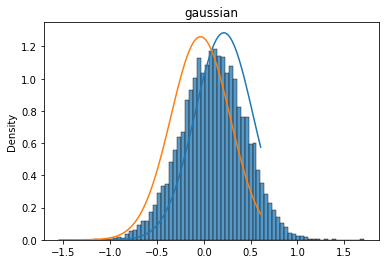

1.0226943
-1.6372948
-0.6766062
tensor([0.4934, 0.5066], dtype=torch.float64)


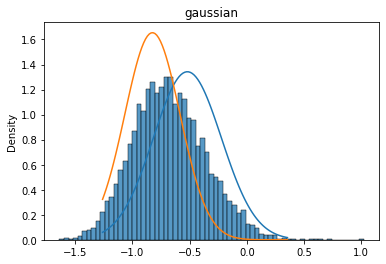

0.608374
-2.265008
-0.9989493
tensor([0.4936, 0.5064], dtype=torch.float64)


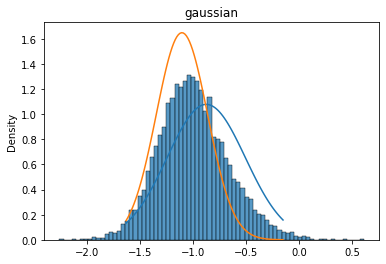

1.6482954
-0.64796084
0.66613996
tensor([0.6136, 0.3864], dtype=torch.float64)


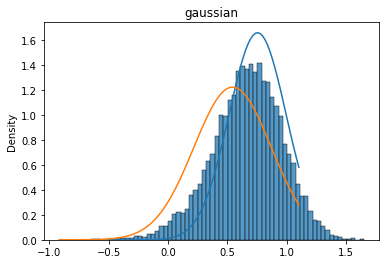

1.3224089
-0.6815904
0.40351132
tensor([0.5857, 0.4143], dtype=torch.float64)


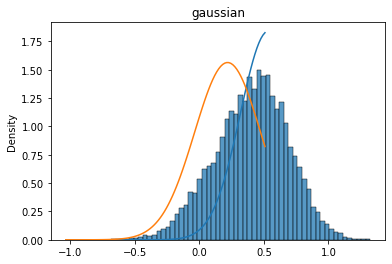

1.1703935
-1.329596
0.024522189
tensor([0.4734, 0.3103, 0.2163], dtype=torch.float64)


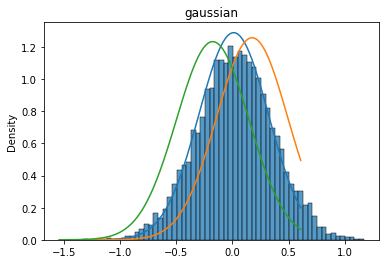

0.798144
-1.8205413
-0.59996504
tensor([0.4675, 0.2899, 0.2426], dtype=torch.float64)


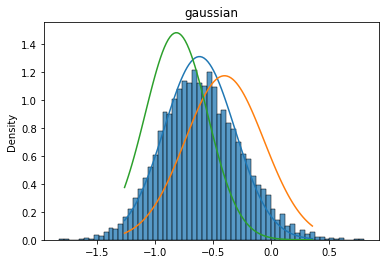

0.8913258
-2.1514745
-0.89551574
tensor([0.4592, 0.3086, 0.2322], dtype=torch.float64)


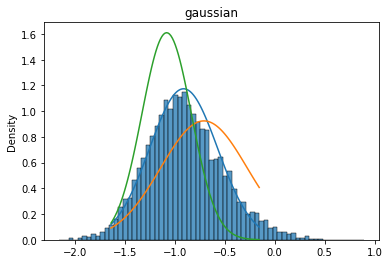

1.9965134
-1.2405454
0.5597063
tensor([0.4658, 0.3161, 0.2180], dtype=torch.float64)


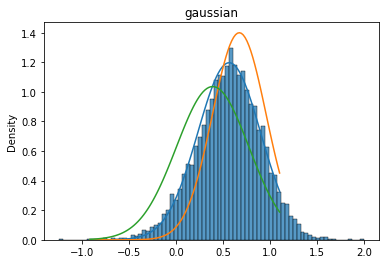

1.4004976
-0.75598353
0.45520753
tensor([0.4451, 0.3410, 0.2139], dtype=torch.float64)


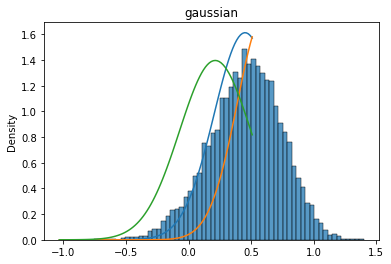

2.2817955
-1.9449953
-0.009164274
tensor([0.4443, 0.5557], dtype=torch.float64)


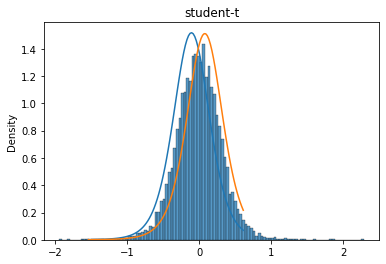

0.79393995
-1.8543934
-0.55995965
tensor([0.4626, 0.5374], dtype=torch.float64)


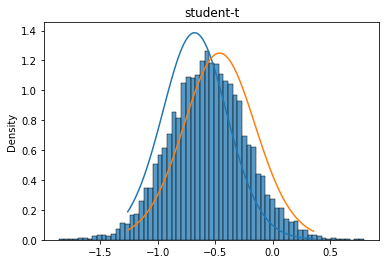

1.2932911
-4.3877583
-0.94860613
tensor([0.4617, 0.5383], dtype=torch.float64)


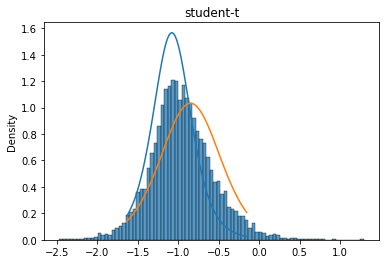

5.963658
-6.2543125
0.7503044
tensor([0.3918, 0.6082], dtype=torch.float64)


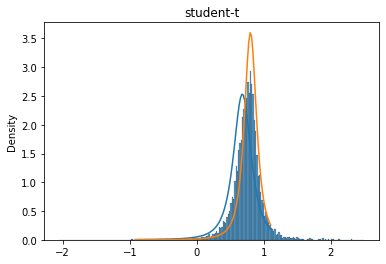

3.212772
-8.580493
0.21365981
tensor([0.4629, 0.5371], dtype=torch.float64)


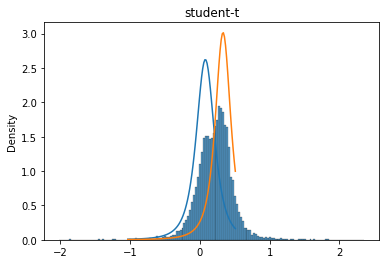

1.9090785
-3.4321063
-0.09980799
tensor([0.2201, 0.3168, 0.4631], dtype=torch.float64)


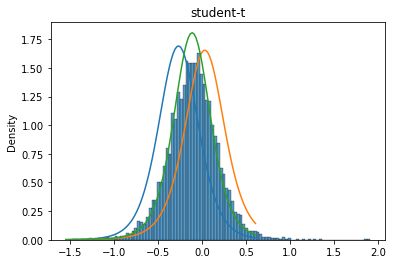

0.79609185
-1.6921974
-0.5348292
tensor([0.2361, 0.2915, 0.4724], dtype=torch.float64)


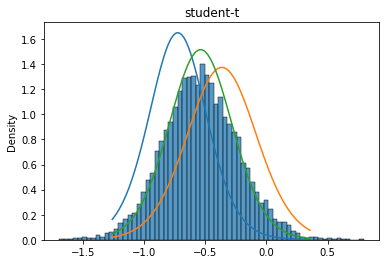

0.6662898
-2.4225168
-0.8159431
tensor([0.2296, 0.3011, 0.4693], dtype=torch.float64)


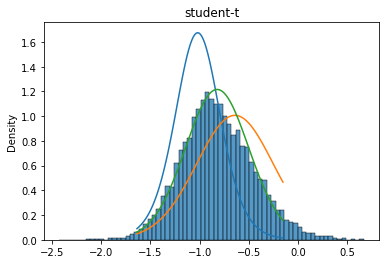

3.6048148
-17.050247
0.8080133
tensor([0.2003, 0.4010, 0.3986], dtype=torch.float64)


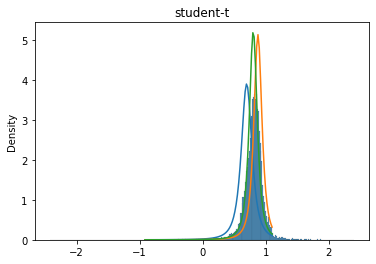

31.523685
-13.547652
0.23440029
tensor([0.2689, 0.3153, 0.4158], dtype=torch.float64)


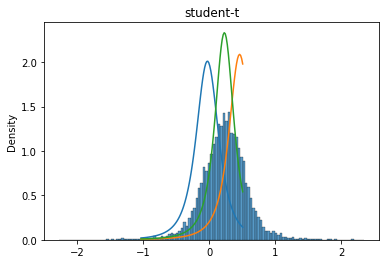

In [16]:
for df, dist in zip(collapsed_dfs, dists):
    for i in random_samples:
        example = df.iloc[i]

        visualize(example, dist=dist)    

In [17]:
df = collapsed_dfs[-1]

In [18]:
temp = df.explode(["predictions"])

In [19]:
np.argmax(temp["predictions"])

3836236

In [20]:
sorted_predictions = np.sort(temp["predictions"])

In [21]:
sorted_predictions

array([-1.6720567, -1.6720567, -1.6720567, ..., 1.3583612, 1.3583612,
       1.3583612], dtype=object)

In [22]:
faulty = temp.iloc[1126750]

In [23]:
print(faulty["locs"])
print(faulty["locs"])

[0.7042796  0.95034409 0.84226185]
[0.7042796  0.95034409 0.84226185]


In [24]:
print(faulty["degrees_of_freedom"])

[2.52058125 2.10005522 2.1026485 ]


6.264652
-5.4498
0.85454774
tensor([0.2041, 0.3814, 0.4146], dtype=torch.float64)


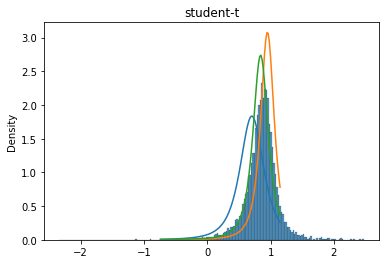

In [25]:
visualize(faulty, dist='student-t')   

In [26]:
stud = td.StudentT(1.2,)

In [27]:
xs = [i for i in np.arange(-20, 20, step=0.1)]

In [28]:
pdf = torch.exp(stud.log_prob(torch.tensor(xs)))

In [29]:
# np.max(stud.sample((1000, )).flatten().numpy())
# np.min(stud.sample((1000, )).flatten().numpy())
np.mean(stud.sample((int(1e6), )).flatten().numpy())

0.21119976

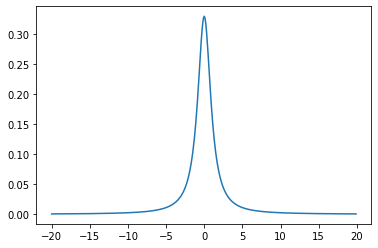

In [30]:
plt.plot(xs, pdf)

In [31]:
np.median(stud.sample((int(1e5), )).flatten().numpy())

0.0006580043

In [32]:
np.mean(stud.sample((int(1e8), )).flatten().numpy())

0.0054136217

In [33]:
np.var(stud.sample((int(1e5), )).flatten().numpy())

1805.9124

In [34]:
faulty

source                Ich habe sie vor drei Jahren im Winter kenneng...
hypotheses                     I met her in the winter three years ago.
locs                  [0.7042796015739441, 0.9503440856933594, 0.842...
scales                [0.1971120536327362, 0.11523820459842682, 0.12...
logit_weights         [-0.4199746251106262, 0.20541460812091827, 0.2...
degrees_of_freedom    [2.5205812454223633, 2.10005521774292, 2.10264...
predictions                                                    0.419334
references_count      [140, 1, 15, 6, 270, 2, 27, 12, 96, 60, 8, 55,...
utilities             [1.149762, 0.8841397, 1.0694792, 0.9987417, 1....
utility                                                        0.873142
utils_collapsed       [1.149762, 1.149762, 1.149762, 1.149762, 1.149...
loss                                                     tensor(0.1061)
Name: 415, dtype: object

In [35]:
np.random.seed(0)
random_samples = np.random.choice(len(df_collapsed.index), 4)

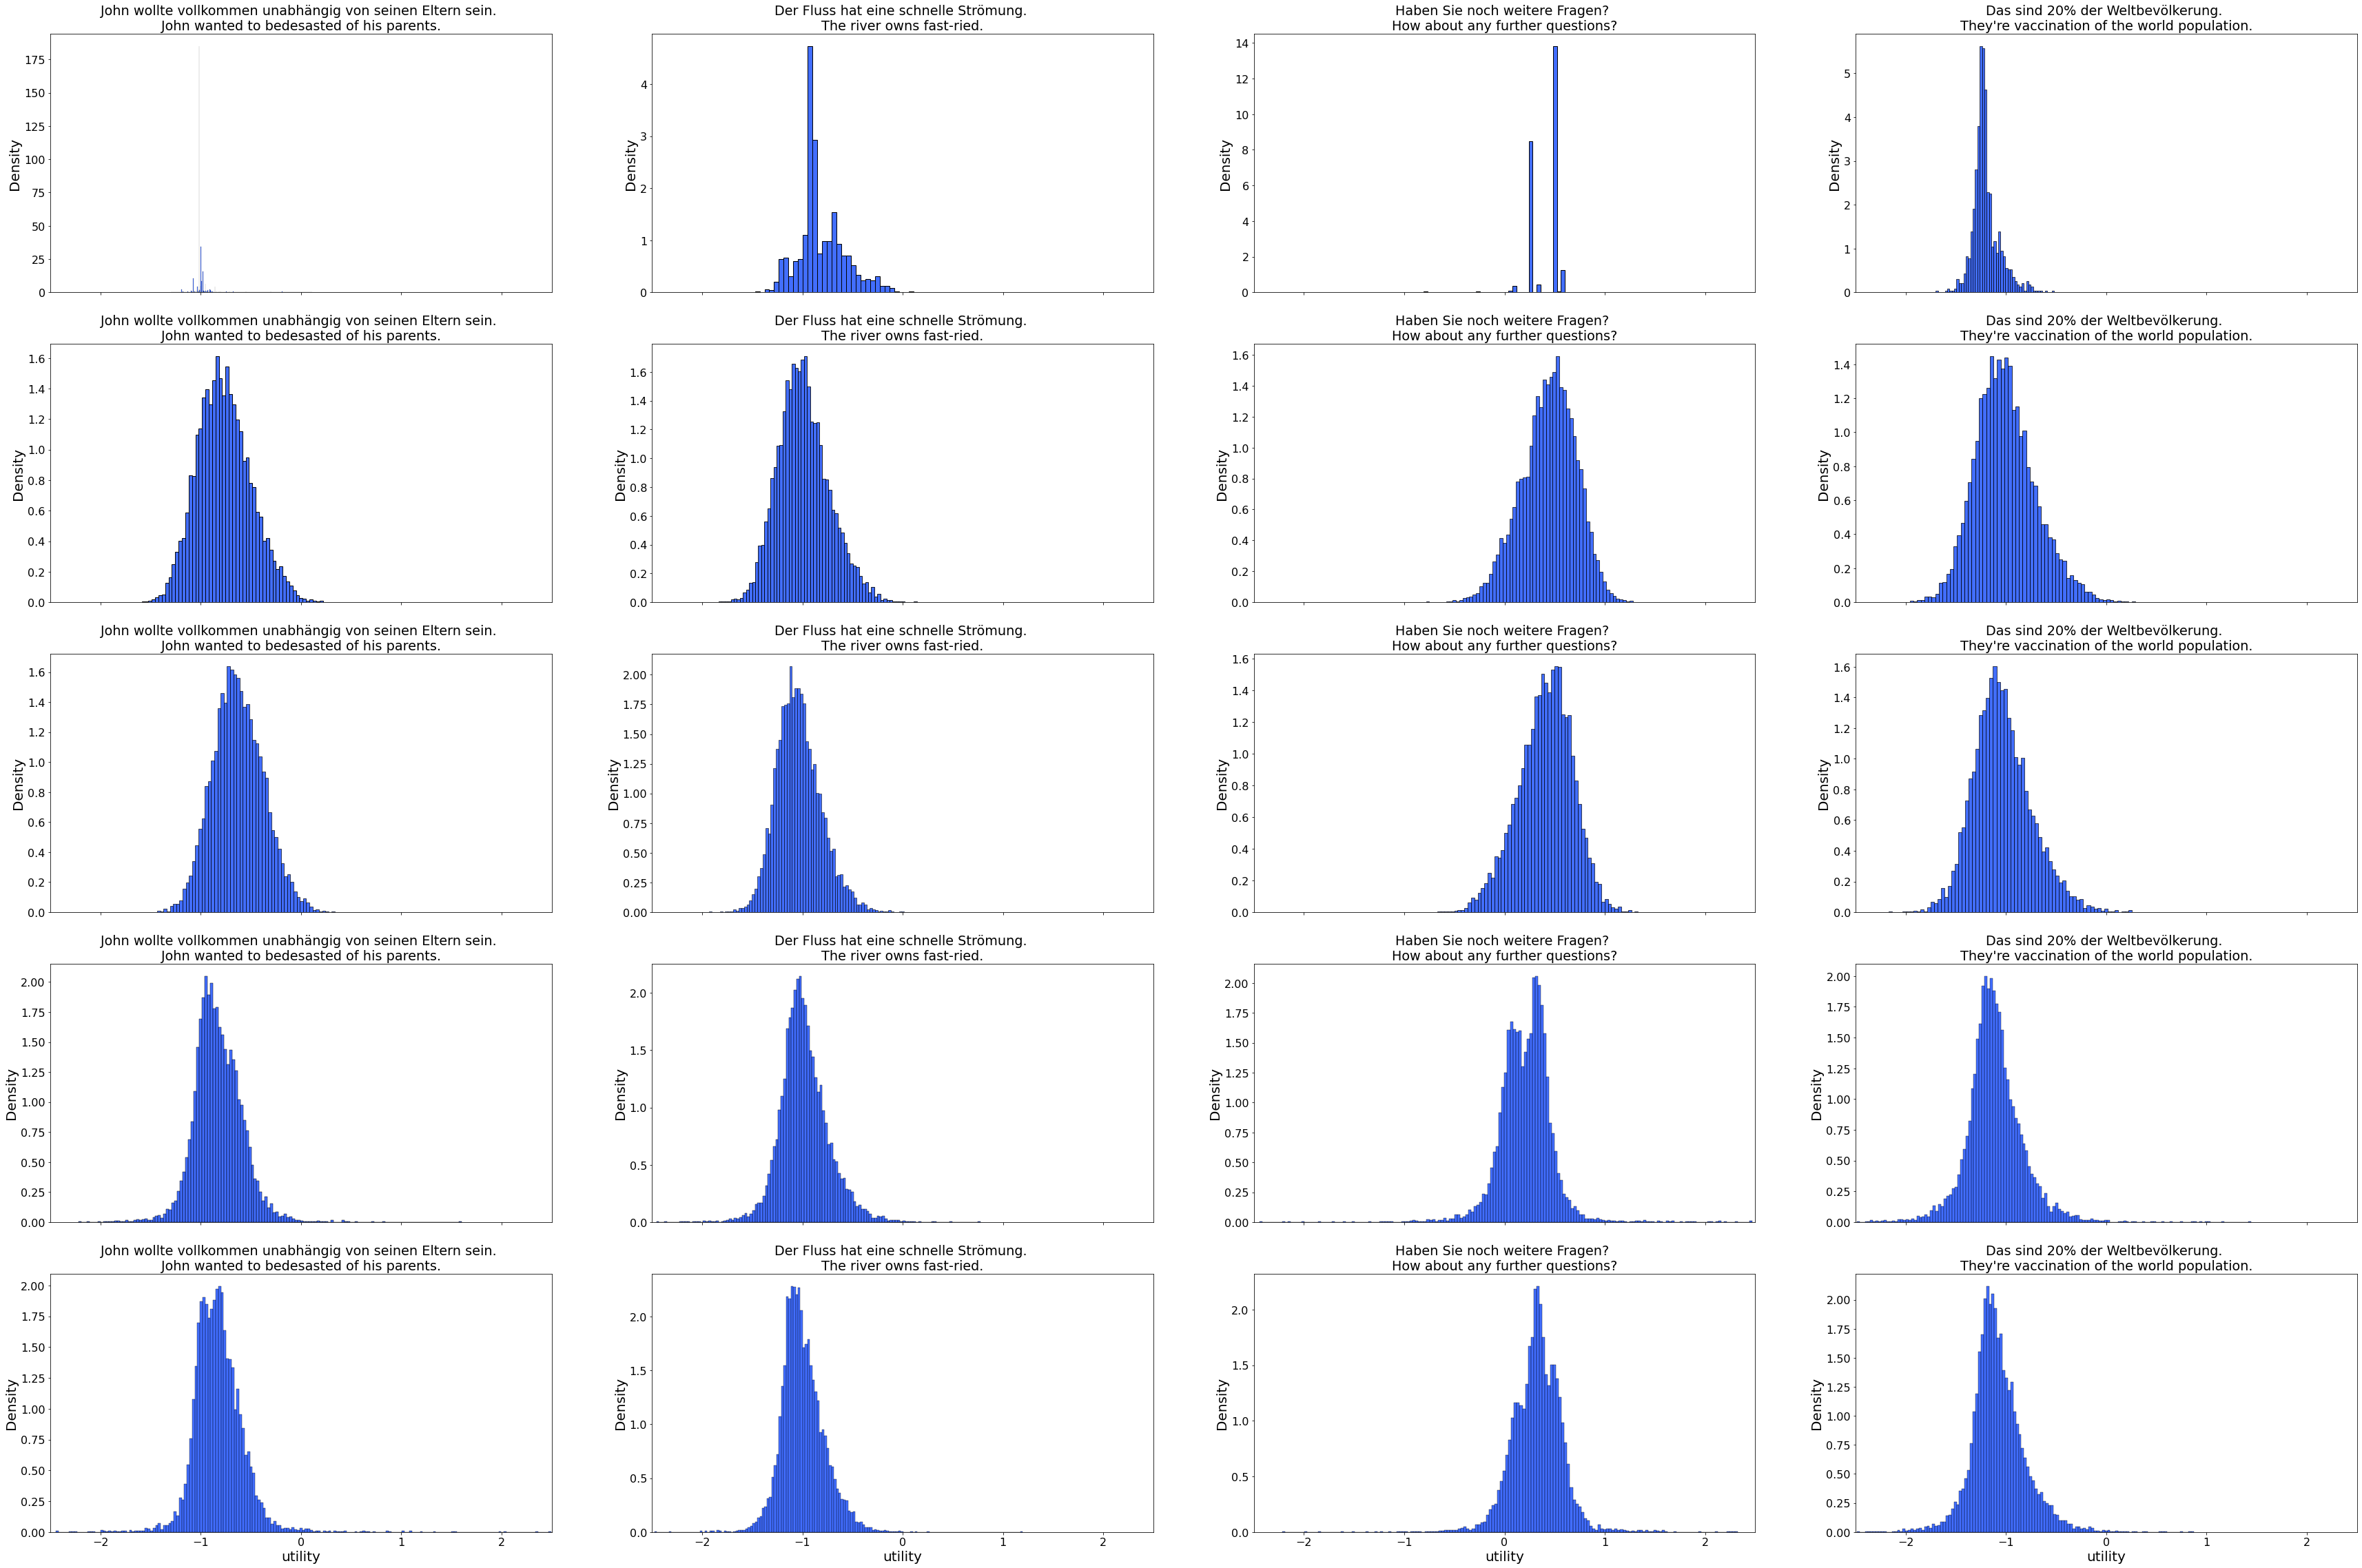

In [37]:
import itertools
fig, (axs) = plt.subplots(5, 4, figsize=(60,40), sharex=True,)
color_palette = itertools.cycle(sns.color_palette('bright'))
plt.rcParams.update({'font.size': 16})

color = next(color_palette)


# First visualize the sample

first_col = axs[0]
df = collapsed_dfs[0]
for j, i in enumerate(random_samples):
    ax = first_col[j]
    example = df.iloc[i]
    utilities = example["utilities"]
    counts = example["references_count"]
    x = []
    for util, count in zip(utilities, counts):
        x += [util] * count
   
    sns.histplot(x,  color=color, stat="density",  ax=ax)
    ax.set_xlabel('Utility',  size=20)
    ax.set_ylabel('Density' ,  size=20)
    ax.set_title("{} \n{}".format(example["source"], example["hypotheses"]))


n_samples = int(1e4)

for col, df, dist in zip(axs[1:], collapsed_dfs, dists ):
    
    for j,  i in enumerate(random_samples):
        
        
        ax = col[j]
        row = df.iloc[i]
        example = df.iloc[i]
        mixture = dist_classes[dist]()
        if dist == 'gaussian':
            samples = mixture.sample(row['locs'], row['scales'], row['logit_weights'], n_samples)
        else:
            samples = mixture.sample(row['degrees_of_freedom'], row['locs'], row['scales'], row['logit_weights'], n_samples)
        
        #Clean for better showing
        samples = samples[samples > -2.5]
        samples = samples[samples < 2.5]
        
        sns.histplot(samples,  color=color, stat="density",  ax=ax)
        #sns.kdeplot(samples,  color=color,  ax=ax)
        ax.set_xlabel('utility',  size=20)
        ax.set_ylabel('Density' ,  size=20)
        ax.set_title("{} \n{}".format(example["source"], example["hypotheses"]))
plt.xlim([-2.5, 2.5])
plt.show()
    
    


# for i, sample in enumerate(random_samples):
#     ax = axs[i]
#     example = df.iloc[sample]
#     utilities = example["utilities"][0]
#     counts = example["references_count"]
#     x = []
#     for util, count in zip(utilities, counts):
#         x += [util] * count
#     ax.hist(x, bins=100, color=color)
#     ax.set_xlabel('utility',  size=20)
#     ax.set_ylabel('count' ,  size=20)
#     ax.set_title("{} \n{}".format(example["source"], example["hypotheses"][0]))
# plt.show()